# **Practical Project**

The aim of this project is to implement a few strategies for portfolio optimization - especially large scale ones involving a large number of stocks and complicated modeling constraints.

In [682]:
# Load the required packages 
using JuMP, Juniper, ECOS, Ipopt, GLPK
using CSV, Glob, DataFrames, Statistics
using Plots
using LinearAlgebra

## Part I - Compulsory Task

#### Data Preprocessing
The first step is to load the raw data into the memory. To do so, we can directly apply the codes demonstrated during the computing lab as follows.

In [688]:
# Data Retrieval
path_subgroup = "C:/Users/Acer/Downloads/FTEC2101/Final Project/group_2/group_2/" # change "group_1" to your assigned group number
files = glob( "*_train.csv", path_subgroup );
dfs = DataFrame.( CSV.File.( files, types=Dict(7=>String) ) );

In [690]:
# Select n stocks for T days 
T = 50; n = length(dfs);
stocks_return = zeros(T,n);
for i = 1:n
    # compute the realized return R_i(t)
    stocks_return[:,i] = (dfs[i].Close-dfs[i].Open) ./ dfs[i].Open*100;
end
names_stocks = [ dfs[i].Ticker[1] for i in 1:n ];

The following code plots the return of a certain stock over time.

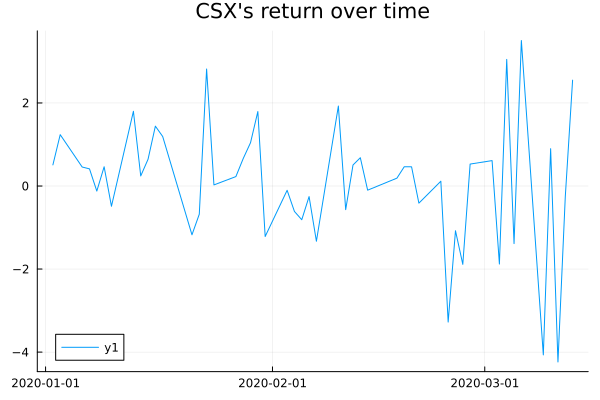

In [694]:
stock_id = 1; 
plot( dfs[stock_id].Date, stocks_return[:,stock_id] , title = dfs[stock_id].Ticker[1]*"'s return over time" ,xrotation = 0)

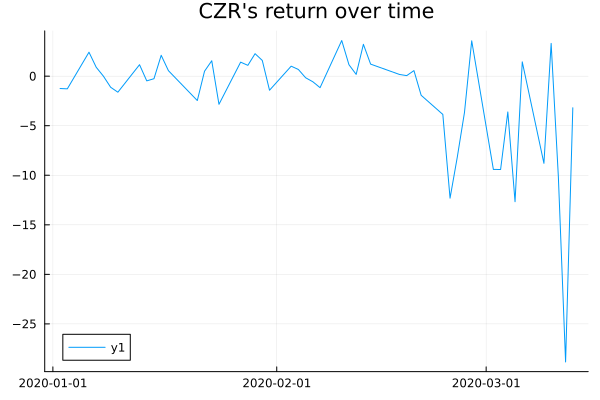

In [695]:
stock_id = 2; 
plot( dfs[stock_id].Date, stocks_return[:,stock_id] , title = dfs[stock_id].Ticker[1]*"'s return over time" ,xrotation = 0)

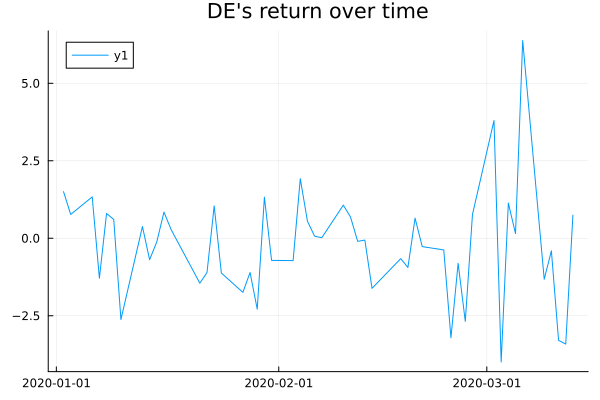

In [696]:
stock_id = 3; 
plot( dfs[stock_id].Date, stocks_return[:,stock_id] , title = dfs[stock_id].Ticker[1]*"'s return over time" ,xrotation = 0)

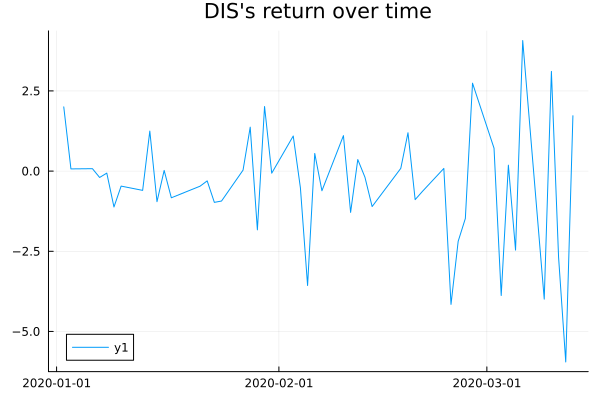

In [697]:
stock_id = 4; 
plot( dfs[stock_id].Date, stocks_return[:,stock_id] , title = dfs[stock_id].Ticker[1]*"'s return over time" ,xrotation = 0)

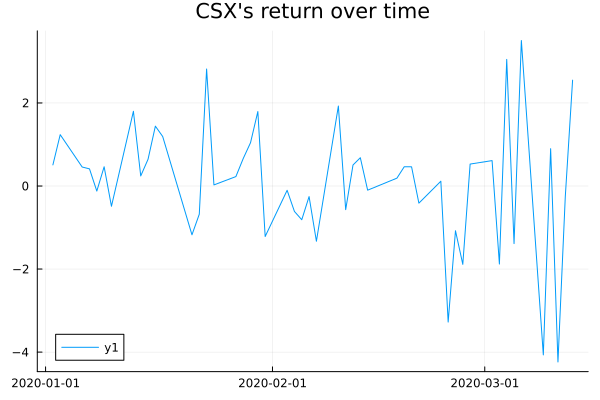

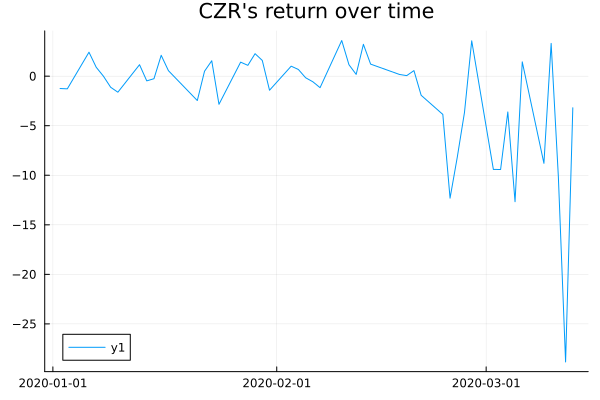

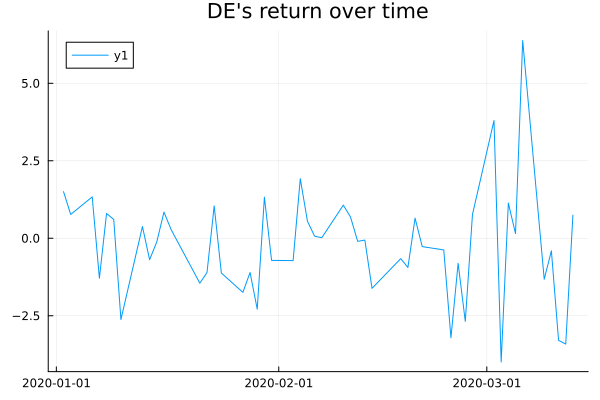

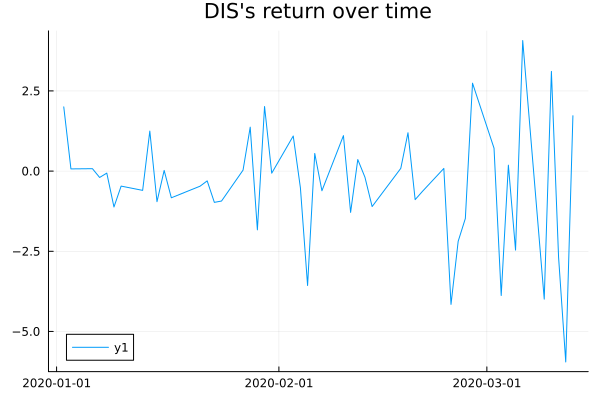

In [698]:
# Show all return of selected stocks and Save PNG
for stock_id in [1, 2, 3, 4] 
    p = plot( dfs[stock_id].Date, stocks_return[:,stock_id] , title = dfs[stock_id].Ticker[1]*"'s return over time" ,xrotation = 0)
    savefig(p, "stock_$(dfs[stock_id].Ticker[1]).png")
    
    # Display the plot
    display(p)
end

In [699]:
# calculate r_i and Sigma
bar_R = [ mean( stocks_return[:,i] ) for i in 1:n ];
Sigma = [ mean( (stocks_return[:,i].-bar_R[i]).*(stocks_return[:,j].-bar_R[j]) ) for i=1:n, j=1:n ]; 

In [729]:
using Statistics, Printf

# Statistical Analysis for the 4 Observed Stocks
println("\nStatistical Analysis of Selected Stocks:")

for stock_id in 1:4
    stock_returns = stocks_return[:, stock_id]
    mean_return = mean(stock_returns) 
    std_return = std(stock_returns) 
    min_return = minimum(stock_returns)
    max_return = maximum(stock_returns) 
    
    # Correct calculation of maximum drawdown
    cumulative_returns = cumprod(1 .+ stock_returns) .- 1
    rolling_max = similar(cumulative_returns)
    drawdown = similar(cumulative_returns)
    
    current_max = cumulative_returns[1]
    for i in 1:length(cumulative_returns)
        current_max = max(current_max, cumulative_returns[i])
        rolling_max[i] = current_max
        drawdown[i] = (cumulative_returns[i] - current_max) / (current_max + 1e-10)
    end
    
    max_drawdown = minimum(drawdown)  # expressed as negative percentage
    
    ticker = dfs[stock_id].Ticker[1]
    @printf "Stock: %s\n" ticker
    @printf "  Mean Daily Return: %.2f%%\n" mean_return
    @printf "  Standard Deviation: %.2f%%\n" std_return
    @printf "  Minimum Return: %.2f%%\n" min_return
    @printf "  Maximum Return: %.2f%%\n" max_return
    @printf "  Maximum Drawdown: %.2f%%\n" max_drawdown
    println("------------------------")
end


Statistical Analysis of Selected Stocks:
Stock: CSX
  Mean Daily Return: 0.09%
  Standard Deviation: 1.56%
  Minimum Return: -4.24%
  Maximum Return: 3.50%
  Maximum Drawdown: -3.59%
------------------------
Stock: CZR
  Mean Daily Return: -1.90%
  Standard Deviation: 5.62%
  Minimum Return: -28.84%
  Maximum Return: 3.60%
  Maximum Drawdown: -29.56%
------------------------
Stock: DE
  Mean Daily Return: -0.23%
  Standard Deviation: 1.79%
  Minimum Return: -3.99%
  Maximum Return: 6.38%
  Maximum Drawdown: -2.04%
------------------------
Stock: DIS
  Mean Daily Return: -0.41%
  Standard Deviation: 1.89%
  Minimum Return: -5.95%
  Maximum Return: 4.07%
  Maximum Drawdown: -1.53%
------------------------


We have now prepared the data that is needed for the portfolio optimization problem. 

### Markowitz Mean-Variance Formulation

*Hint*: you may calculate the matrix square root using the `sqrt()` function

In [613]:
# Test to see return's unit
println("stock return: ", stocks_return[1:n])
println("\nbar_R: ", bar_R)
println("\nMax return: ", maximum(bar_R))


stock return: [0.5081085761778267, 1.2361129124959287, 0.45719290437754084, 0.4126484445873835, -0.1225017840991997, 0.4632128585438638, -0.48833764478979913, 1.7991026128856213, 0.24167345557777503, 0.6442159107437517, 1.440843652681724, 1.1920498883556938, -1.1753847135073896, -0.678914017884582, 2.8172824211976906, 0.026087992799831334, 0.22666931152344208, 0.6603325663383607, 1.0426084712823858, 1.792960183440954]

bar_R: [0.08979718066842429, -1.8968970433674124, -0.22574674995386595, -0.4114842216431675, -0.01754593347563099, 0.3093391498334156, 0.560796792625012, 0.023044572778505988, 0.03745553409614775, -0.14738260235611436, 0.04549132297951775, 0.022702493326504605, 0.109719432231851, 0.07385766919431122, -0.09426684618201638, 0.09990257078262718, -0.6021845268762182, 0.02221773758034427, -0.0984451528235883, -0.27573241028015716]

Max return: 0.560796792625012


In [612]:
# Budget and desired Expected Return constraint, return needs to be 0.01% of budget (in percentage * dollars)
B = 10; Rd = 0.01*B; 

m_markowitz = Model( ECOS.Optimizer );
# the Markowitz portfolio optimization problem, you may wish to use "x_markowitz" to represent the decision variables

# Weight of each stock (in dollars) cannot be negative (no short selling)
@variable(m_markowitz, x_markowitz[1:n] >= 0)
# t constraint (portfolio variance (𝑝⊤ Σ𝑝), reformulated as 𝑡^2, where 𝑝 >= 0, no short selling)
@variable(m_markowitz, t >= 0)
# Total investment (Weight of each stock) equals to budget (in dollars)
@constraint(m_markowitz, sum(x_markowitz) == B)
# Expected return equals to desired return (0.1 dollars)
@constraint(m_markowitz, dot(bar_R, x_markowitz) == Rd)
# [ 𝑡 ; Σ𝑝 ] ∈ SecondOrderCone ensures 𝑡 ≥ sqrt(𝑝⊤ Σ𝑝)
@constraint(m_markowitz, [t; sqrt(Sigma)*x_markowitz] in SecondOrderCone())
# Minimize portfolio variance (risk) for a given return
@objective(m_markowitz, Min, 0.5*t^2)

status = optimize!( m_markowitz );
optimal_portfolio_markowitz = value.(x_markowitz)

20-element Vector{Float64}:
 2.6932078271436278e-8
 4.0009345139484933e-7
 3.6589212410334054e-7
 1.4992572629823389
 1.5503508571998623e-8
 2.002628339660213
 2.2635726694888473e-8
 0.0296340440658951
 0.8087073563725452
 2.2078811485647295e-8
 1.4619577631342398e-7
 7.2590583835486286e-9
 6.496953614747533e-9
 2.1079191475297083
 0.7735782193185972
 2.4945804298635524e-9
 0.0027921478295616043
 2.5194326914407212
 6.587887467325148e-8
 0.25604970934007826


ECOS 2.0.8 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.541e-016  -2.730e-001  +5e+001  6e-001  6e-001  1e+000  2e+000    ---    ---    1  1  - |  -  - 
 1  +2.113e-001  +5.224e-001  +3e+001  2e-001  2e-001  8e-001  1e+000  0.4446  2e-001   1  1  1 |  0  0
 2  +2.426e+001  +4.751e+001  +3e+001  9e+000  2e+000  4e+001  1e+000  0.7389  7e-001   2  2  2 |  0  0
 3  -4.799e+000  +1.348e+001  +2e+001  3e+000  5e-001  2e+001  1e+000  0.2200  5e-001   2  2  1 |  0  0
 4  +4.983e+000  +3.938e+000  +2e+001  8e-001  2e-001  1e-001  8e-001  0.5277  6e-001   2  2  2 |  0  0
 5  +8.976e+000  +1.002e+001  +3e+000  4e-001  4e-002  1e+000  1e-001  0.9890  2e-001   2  2  2 |  0  0
 6  +1.984e+001  +2.040e+001  +1e+000  1e-001  2e-002  7e-001  5e-002  0.6618  1e-001   2  2  2 |  0  0
 7  +1.729e+001  +1.922e+001  +8e-001  4e-001  3e-002  2e+000  3e-002  0.7153  4e-001  

### CVAR with LP formulation

In [722]:
B = 10; Rd = 0.01*B; 
alp = 0.95; # confidence level 
T, n = size(stocks_return)

m_cvar = Model( GLPK.Optimizer );
# the CVAR problem, you may wish to use "x_cvar" to represent the decision variables

# Weight of portfolio (in dollars)
@variable(m_cvar, x_cvar[1:n] >= 0)
# Threshold for VAR
@variable(m_cvar, beta)
# loss constraint 𝑧𝑡 ≥ − 𝑝⊤ ( 𝑅𝑡 / 100 ) − 𝛽, where 𝑅𝑡​ is stocks_return[t,:]
@variable(m_cvar, z[1:T] >= 0)
# Turn return to (decimals), Stock return is in percentage
@constraint(m_cvar, [t=1:T], z[t] >= -dot(stocks_return[t,:]/100, x_cvar) - beta)
# Portfolio total investment less than budget
@constraint(m_cvar, sum(x_cvar) <= B)
# Total Return greater than desired (in Percentage * dollars)
@constraint(m_cvar, dot(bar_R, x_cvar) >= Rd)
# Minimize CVaR (expected loss in the worst 5% of scenarios, 𝛼 = 0.95).
@objective(m_cvar, Min, beta + 1/(1-alp) * 1/T * sum(z))

status = optimize!( m_cvar )
optimal_portfolio_cvar = value.(x_cvar)

20-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.1408144662667464
 0.09271662605781986
 0.0
 0.0
 0.0
 0.0
 0.0
 0.04051594247377114
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

### CVAR with MILP Formulation

In [724]:
B = 10; Rd = 0.01*B; # in decimals * dollars
m = 5; min_ratio = 0.01;
alp = 0.95; # confidence level

m_cvar_ip = Model( GLPK.Optimizer );
set_optimizer_attribute(m_cvar_ip, "msg_lev", GLPK.GLP_MSG_ALL);
# the CVAR-IP problem, you may wish to use "x_cvar_ip" to represent the decision variables

# Weight of portfolio (in dollars)
@variable(m_cvar_ip, x_cvar_ip[1:n] >= 0)
# Threshold for VAR
@variable(m_cvar_ip, beta)
# loss constraint 𝑧𝑡 ≥ − 𝑝⊤ ( 𝑅𝑡 / 100 ) − 𝛽, where 𝑅𝑡​ is stocks_return[t,:]
@variable(m_cvar_ip, z[1:T] >= 0)
# Binary for selecting stocks
@variable(m_cvar_ip, y[1:n], Bin)
# Turn return to (decimals), Stock return is in percentage
@constraint(m_cvar_ip, [t=1:T], z[t] >= -dot(stocks_return[t,:]/100, x_cvar_ip) - beta)
# Portfolio total investment less than budget
@constraint(m_cvar_ip, sum(x_cvar_ip) <= B)
# Total Return greater than desired (in Percentage * dollars)
@constraint(m_cvar_ip, dot(bar_R, x_cvar_ip) >= Rd)
# Allocation of stocks At least 𝑚 stocks
@constraint(m_cvar_ip, sum(y) >= m)
# Portfolio allocation (in dollars) more than minimum allocation ratio
@constraint(m_cvar_ip, [i=1:n], x_cvar_ip[i] >= min_ratio*B*y[i])
# Allocation less than budget
@constraint(m_cvar_ip, [i=1:n], x_cvar_ip[i] <= B*y[i])
# Minimize CVaR (expected loss in the worst 5% of scenarios, 𝛼 = 0.95).
@objective(m_cvar_ip, Min, beta + 1/(1-alp) * 1/T * sum(z))

status = optimize!( m_cvar_ip )
optimal_portfolio_cvar_ip = value.(x_cvar_ip)

GLPK Simplex Optimizer 5.0
93 rows, 91 columns, 1231 non-zeros
      0: obj =  0.000000000e+000 inf =  5.100e+000 (2)
     24: obj =  1.894864519e-002 inf =  0.000e+000 (0)
*    49: obj =  8.462320482e-003 inf =  2.741e-015 (0)
OPTIMAL LP SOLUTION FOUND
GLPK Integer Optimizer 5.0
93 rows, 91 columns, 1231 non-zeros
20 integer variables, all of which are binary
Integer optimization begins...
Long-step dual simplex will be used
+    49: mip =     not found yet >=              -inf        (1; 0)
+    59: >>>>>  8.648434869e-003 >=  8.648434869e-003   0.0% (8; 0)
+    59: mip =  8.648434869e-003 >=     tree is empty   0.0% (0; 15)
INTEGER OPTIMAL SOLUTION FOUND


20-element Vector{Float64}:
  0.1
  0.0
  0.0
  0.0
  0.0
  0.1
  0.11999226581700315
  0.0
  0.0
  0.0
  0.0
  0.0
 -1.0434104543644138e-18
  0.0
  0.1
  3.3955292423310126e-19
  0.0
  0.1
  0.0
  0.0

### SOCP-MIP Formulation

In [619]:
B = 10; Rd = 0.01*B; m = 5; min_ratio = 0.01;

nl_solver = optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)
optimizer = Juniper.Optimizer
m_markowitz_ip = Model(optimizer_with_attributes(Juniper.Optimizer, 
                "nl_solver"=>nl_solver, "atol"=>1e-8, "time_limit" => 120));

# the Markowitz portfolio optimization with mixed IP, you may wish to use "x_markowitz_ip" to represent the decision variables

# Weight of portfolio (in dollars)
@variable(m_markowitz_ip, x_markowitz_ip[1:n] >= 0)
# Binary for selecting stocks
@variable(m_markowitz_ip, y[1:n], Bin)
# Portfolio total investment equals budget
@constraint(m_markowitz_ip, sum(x_markowitz_ip) == B)
# Portfolio total return equals desired return (in Percentage * dollars)
@constraint(m_markowitz_ip, dot(bar_R, x_markowitz_ip) == Rd)
# Allocation of stocks At least 𝑚 stocks
@constraint(m_markowitz_ip, sum(y) >= m)
# Portfolio allocation (in dollars) more than minimum allocation ratio
@constraint(m_markowitz_ip, [i=1:n], x_markowitz_ip[i] >= min_ratio*B*y[i])
# Allocation less than budget
@constraint(m_markowitz_ip, [i=1:n], x_markowitz_ip[i] <= B*y[i])
# Markowitz Objective function, minimize variance (risk)
@objective(m_markowitz_ip, Min, dot(x_markowitz_ip, Sigma*x_markowitz_ip))

optimize!(m_markowitz_ip)
optimal_portfolio_markowitz_ip = value.(x_markowitz_ip)

atol              : 1.0e-8
nl_solver         : MathOptInterface.OptimizerWithAttributes(Ipopt.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawOptimizerAttribute("print_level") => 0])
time_limit        : 120.0
feasibility_pump  : false
log_levels        : [:Options, :Table, :Info]

#Variables: 40
#IntBinVar: 20
Obj Sense: Min

Start values are not feasible.
Status of relaxation: LOCALLY_SOLVED
Time for relaxation: 0.5260000228881836
Relaxation Obj: 94.94611541896079

 ONodes   CLevel          Incumbent                   BestBound            Gap    Time   Restarts  GainGap  
    2       2                 -                         94.95               -     2.7       0         -     
    3       3                 -                         94.95               -     2.9       -       74.7%   
    4       4                 -                         94.95               -     3.0       -       75.3%   
    5       5                 -                        

20-element Vector{Float64}:
 -8.915995350496884e-9
  4.1840751002602984e-9
 -3.156866050302298e-9
  1.5122058995247898
 -9.413375779099044e-9
  2.0074910926047687
 -9.139965237350705e-9
  6.763218841972077e-9
  0.808075338353699
 -9.1445356058976e-9
 -7.400689496267427e-9
 -9.743047339228756e-9
 -9.764951574229889e-9
  2.1313522594561056
  0.7797347618945254
 -9.899481544424365e-9
  4.295001086705367e-9
  2.5118591801503145
 -8.381407437643267e-9
  0.24928153773381834

In [620]:
println("Portfolio return (Markowitz): ", dot(bar_R, optimal_portfolio_markowitz))
println("Portfolio return (CVaR): ", dot(bar_R, optimal_portfolio_cvar))
println("Portfolio return (CVaR MILP): ", dot(bar_R, optimal_portfolio_cvar_ip))
println("Portfolio return (Markowitz MINLP): ", dot(bar_R, optimal_portfolio_markowitz_ip))

Portfolio return (Markowitz): 0.100000000049188
Portfolio return (CVaR): 0.1
Portfolio return (CVaR MILP): 0.1
Portfolio return (Markowitz MINLP): 0.09999999999999988


### Task 5: Comparing the Portfolios

(a) Plot and compare the portfolios:

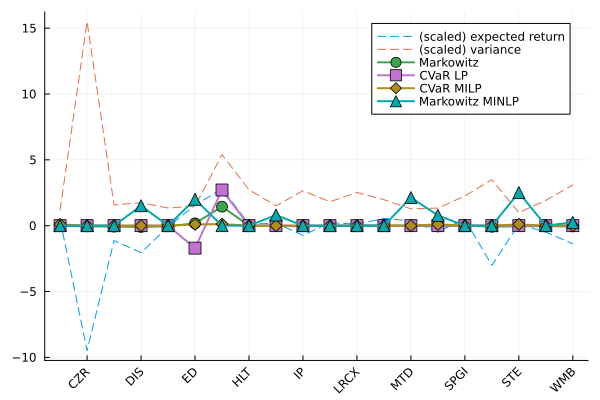

In [711]:
# to get it started, we plot the expected return and variance of each stock below
plot( names_stocks, 5*bar_R , labels = "(scaled) expected return", linestyle=:dash )
plot!( names_stocks, 0.5*[Sigma[i,i] for i in 1:n], labels = "(scaled) variance", linestyle=:dash, xrotation = 45 )

# below you should plot the portfolios and compare them against each other
plot!(names_stocks, value.(x_markowitz), label = "Markowitz", linewidth = 2, marker = :circle, markersize = 6)
plot!(names_stocks, value.(x_cvar), label = "CVaR LP", linewidth = 2, marker = :square, markersize = 6)
plot!(names_stocks, value.(x_cvar_ip), label = "CVaR MILP", linewidth = 2, marker = :diamond, markersize = 6)
plot!(names_stocks, value.(x_markowitz_ip), label = "Markowitz MINLP", linewidth = 2, marker = :utriangle, markersize = 6)

(b) Sharpe Ratio on Test Data

In [628]:
include("reusablefunc.jl")

performance_extradata (generic function with 1 method)

In [630]:
sharpe_CVAR = performance_testdata( path_subgroup, value.(x_cvar) );

(Test) Sharpe Ratio = 0.08414123185650917, Return = 0.0007598608095568936
 R-R ratio = -Inf Variance = 8.155495644012171e-5, Selected stocks = 3


In [631]:
sharpe_Markowitz = performance_testdata( path_subgroup, value.(x_markowitz) );

(Test) Sharpe Ratio = 0.17678859251474632, Return = 0.05623390167202402
 R-R ratio = 8.680414250493758 Variance = 0.10117843506892837, Selected stocks = 8


In [632]:
sharpe_CVAR_IP = performance_testdata( path_subgroup, value.(x_cvar_ip) );

(Test) Sharpe Ratio = 0.26511413596163924, Return = 0.003707361856190426
 R-R ratio = 2.0909603915827515e19 Variance = 0.00019555286564112927, Selected stocks = 5


In [633]:
sharpe_Markowitz_IP = performance_testdata( path_subgroup, value.(x_markowitz_ip) );

(Test) Sharpe Ratio = 0.17716508683078352, Return = 0.05661140501023431
 R-R ratio = 8.74552143525894 Variance = 0.10210607552269686, Selected stocks = 7


### Task 6: Pareto Front of the Algorithms

First we should evaluate the risks for different approaches under different settings for $R_d$. 

In [636]:
B = 1; C = sqrt(Sigma);
alp = 0.95; # confidence level

# return between -0.99% and 0.99% with step size of 0.01
list_Rd = (-0.99:0.01:0.99)*B; 

store_CVAR_LP = []
store_CVAR_Markowitz = []
store_Var_LP = []
store_Var_Markowitz = []
list_Rd_Feasible = []

# this for-loop goes through the list of possible Rd in "list_Rd"
for Rd_current in list_Rd

    m_cvar = Model( GLPK.Optimizer );
    ## solve the CVAR problem with "Rd_current" like in Task 4-b but with *equality constraint* for expected return, you may use "x_cvar" as the variable name ##

    # Weight of portfolio (in dollars)
    @variable(m_cvar, x_cvar[1:n] >= 0)
    # Threshold for VAR
    @variable(m_cvar, beta)
    # loss constraint 𝑧𝑡 ≥ − 𝑝⊤ ( 𝑅𝑡 / 100 ) − 𝛽, where 𝑅𝑡​ is stocks_return[t,:]
    @variable(m_cvar, z[1:T] >= 0)
    # Turn return to percentage (decimals), Stock return in dollar
    @constraint(m_cvar, [t=1:T], z[t] >= -dot(stocks_return[t,:]/100, x_cvar) - beta)
    # Portfolio total investment less than budget
    @constraint(m_cvar, sum(x_cvar) <= B)
    # Total Return greater than desired (in dollars)
    @constraint(m_cvar, dot(bar_R, x_cvar) == Rd_current)
    # Minimize CVaR (expected loss in the worst 5% of scenarios, 𝛼 = 0.95).
    @objective(m_cvar, Min, beta + 1/(1-alp) * 1/T * sum(z))

    status = optimize!( m_cvar )

    if( termination_status( m_cvar ) == INFEASIBLE ) 
        # note that for some value of Rd, the CVAR problem may be infeasible
    else 
        push!( store_Var_LP, value.(x_cvar)'*Sigma*value.(x_cvar) )
        push!( store_CVAR_LP, objective_value(m_cvar) )
        push!( list_Rd_Feasible, Rd_current )
    end

    ## solve the Markowtiz problem with "Rd_current" like in Task 4-a but with *equality constraint* for expected return, you may use "x_markowitz" as the variable name ##
   
    m_markowitz = Model( ECOS.Optimizer );
    set_attribute(m_markowitz, "verbose", 0)
    # solve the Markowitz problem

    # Weight of each stock (in dollars) cannot be negative (no short selling)
    @variable(m_markowitz, x_markowitz[1:n] >= 0)
    # t constraint (portfolio variance (𝑝⊤ Σ𝑝), reformulated as 𝑡^2, where 𝑝 >= 0, no short selling)
    @variable(m_markowitz, t >= 0)
    # Total investment (Weight of each stock) equals to budget (in dollars)
    @constraint(m_markowitz, sum(x_markowitz) == B)
    # Expected return equals to desired return (in dollars)
    @constraint(m_markowitz, dot(bar_R, x_markowitz) == Rd_current)
    # [ 𝑡 ; Σ𝑝 ] ∈ SecondOrderCone ensures 𝑡 ≥ sqrt(𝑝⊤ Σ𝑝)
    @constraint(m_markowitz, [t; sqrt(Sigma)*x_markowitz] in SecondOrderCone())
    # Minimize portfolio variance (risk) for a given return
    @objective(m_markowitz, Min, t^2)
    
    status = optimize!( m_markowitz )

    # 

    if( termination_status( m_markowitz ) == INFEASIBLE )
        # note that for some value of Rd, the Markowitz problem may be infeasible
    else
        # calculate the CVAR for "x_markowitz" and store it into "calc_cvar"
        # use "value.(x_markowitz)" to get the optimal portfolio and proceed with the CVaR calculation, you may need to code up another LP to find the CVAR

        # Value of portfolio allocation, budget and return constraint
        x_m = value.(x_markowitz)
        m_cvar_temp = Model(GLPK.Optimizer)

        # CVaR formula
        # Threshold for VAR
        @variable(m_cvar_temp, beta)
        # loss constraint 𝑧𝑡 ≥ − 𝑝⊤ ( 𝑅𝑡 / 100 ) − 𝛽, where 𝑅𝑡​ is stocks_return[t,:]
        @variable(m_cvar_temp, z[1:T] >= 0)
        # Turn return to percentage (decimals), Stock return in dollar
        @constraint(m_cvar_temp, [t=1:T], z[t] >= -dot(stocks_return[t,:]/100, x_m) - beta)
        # Optimal Beta Minimize CVaR (expected loss in the worst 5% of scenarios, 𝛼 = 0.95).
        @objective(m_cvar_temp, Min, beta + 1/(1-alp) * 1/T * sum(z))
        optimize!(m_cvar_temp)
        calc_cvar = objective_value(m_cvar_temp)
        
        push!( store_Var_Markowitz, value.(x_markowitz)'*Sigma*value.(x_markowitz) )
        push!( store_CVAR_Markowitz, calc_cvar )
    end
end

Pareto Plots with CVAR as Risk Measure

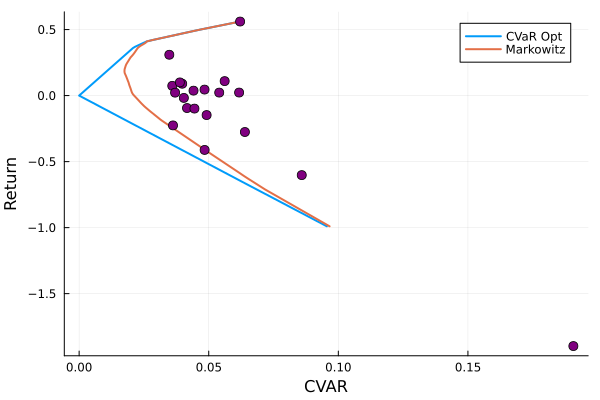

"C:\\Users\\Acer\\Downloads\\FTEC2101\\Final Project\\cvar_vs_return.png"

In [639]:
plt = plot( store_CVAR_LP, list_Rd_Feasible, label="CVaR Opt", linewidth=2 )
plot!( store_CVAR_Markowitz, list_Rd_Feasible, label="Markowitz", linewidth=2 )

# plot the CVAR for each stock
for i = 1 : n  
    # calculate the CVAR for stock "i" and store it into "calc_cvar"
    # like in the previous cell, you may need to code up another LP to find the CVAR
    # Calculate CVaR for stock i by setting p_i = B, others 0
    x_stock = zeros(n)
    x_stock[i] = B  # Invest entire budget in stock i
    m_cvar_temp = Model(GLPK.Optimizer)
    @variable(m_cvar_temp, beta)
    @variable(m_cvar_temp, z[1:T] >= 0)
    @constraint(m_cvar_temp, [t=1:T], z[t] >= -dot(stocks_return[t,:]/100, x_stock) - beta)
    @objective(m_cvar_temp, Min, beta + 1/(1-alp) * 1/T * sum(z))
    optimize!(m_cvar_temp)
    
    calc_cvar = objective_value(m_cvar_temp)
    
    plot!( [calc_cvar], [bar_R[i]], markersize=5, marker=:circle, color=:purple, label ="" )
end
xlabel!("CVAR")
ylabel!("Return")
display(plt)
savefig(plt, "cvar_vs_return.png")

Pareto Plots with Variance as Risk Measure

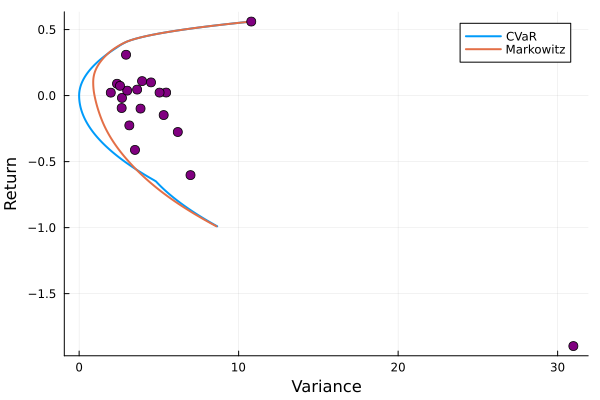

"C:\\Users\\Acer\\Downloads\\FTEC2101\\Final Project\\variance_vs_return.png"

In [641]:
plt = plot( store_Var_LP, list_Rd_Feasible, label = "CVaR", linewidth=2 )
plot!( store_Var_Markowitz, list_Rd_Feasible, label = "Markowitz", linewidth=2 )

# plot the Risk for each stock
for i = 1 : n 
    # selected stock "i" and plot its variance/expected return
    plot!( [Sigma[i,i]], [bar_R[i]], markersize=5, marker=:circle, color=:purple, label ="" )
end
xlabel!("Variance")
ylabel!("Return")
display(plt)
savefig(plt, "variance_vs_return.png")

## Competitive Task

In this task, we shall implement a projected gradient method for the approximated Portfolio optimization problem. 

In [ ]:
# load the full data set!
files = glob( "*_train.csv", "C:/Users/Acer/Downloads/FTEC2101/Final Project/full_data_final/full_data_final/");
dfs = DataFrame.( CSV.File.( files ) );
T = 1000; n = length(dfs);
stocks_return_full = zeros(T,n);
for i = 1:n
    if length(dfs[i].Close) < 1000
        print("Stock ", dfs[i].Ticker[1], " has less than 1000 data points")
    end
    # compute the realized return R_i(t)
    stocks_return_full[:,i] = (dfs[i].Close-dfs[i].Open) ./ dfs[i].Open;
end
names_stocks_full = [ dfs[i].Ticker[1] for i in 1:n ];
# calculate r_i and Sigma
bar_R_full = Float64[ mean( stocks_return_full[:,i] ) for i in 1:length(dfs) ];
Sigma_full = [ mean( (stocks_return_full[:,i].-bar_R_full[i]).*(stocks_return_full[:,j].-bar_R_full[j]) ) for i=1:n, j=1:n ];

In [ ]:
bar_R_full = Float64[mean(stocks_return_full[:,i]) for i in 1:length(dfs)]
println("bar_R_full mean: ", mean(bar_R_full), " min: ", minimum(bar_R_full), " max: ", maximum(bar_R_full))
println("stocks_return_full mean: ", mean(stocks_return_full), " std: ", std(stocks_return_full))
Sigma_full = [mean((stocks_return_full[:,i].-bar_R_full[i]).*(stocks_return_full[:,j].-bar_R_full[j])) for i=1:n, j=1:n]

In [739]:
# limited exponential for numerical stability - Do not change this function -
function exp_limit( x )
    return exp( max( -1e2, min( x, 1e2 ) ) )
end

# define the objective functions & gradient
function obj_fct( x, beta, alp, gamma, upsilon, delta, T, bar_R, stocks_return )
    # Objective: CVaR + penalty terms + sparsity penalty
    # CVaR term: beta + (1/(1-alpha)) * (1/T) * sum(h_delta(-p^T R_t - beta))
    cvar_term = beta
    for t = 1:T
        loss = -dot(stocks_return[t,:], x) - beta
        h_delta = delta * log(1 + exp_limit(loss / delta))
        cvar_term += (1/(1-alp)) * (1/T) * h_delta
    end
    
    # Penalty terms
    # f1(p) = sum(p) - B <= 0, where B = 10
    B = 10
    f1 = sum(x) - B
    # f2(p) = Rd - sum(p * bar_R) <= 0, where Rd = 0.1
    Rd = 0.1
    f2 = Rd - dot(bar_R, x)
    
    # Sparsity penalty: gamma_s * sum(1 / (1 + exp(-lambda * p_i)))
    gamma_s = 0.1  # Tunable
    lambda = 10.0  # Tunable
    sparsity_term = 0.0
    for i = 1:length(x)
        sparsity_term += 1 / (1 + exp_limit(-lambda * x[i]))
    end
    sparsity_term *= gamma_s
    
    return cvar_term + gamma * f1 + upsilon * f2 + sparsity_term
end

function grd_fct_x( x, beta, alp, gamma, upsilon, delta, T, bar_R, stocks_return )
    # Gradient of objective w.r.t. x
    n = length(x)
    grad = zeros(n)
    
    # CVaR term gradient
    for t = 1:T
        loss = -dot(stocks_return[t,:], x) - beta
        sigmoid = exp_limit(loss / delta) / (1 + exp_limit(loss / delta))
        grad .+= (1/(1-alp)) * (1/T) * sigmoid * (-stocks_return[t,:])
    end
    
    # Penalty terms gradient
    # f1 = sum(x) - B, grad = ones(n)
    grad .+= gamma * ones(n)
    # f2 = Rd - sum(bar_R * x), grad = -bar_R
    grad .+= upsilon * (-bar_R)
    
    # Sparsity penalty gradient
    gamma_s = 0.1
    lambda = 10.0
    for i = 1:n
        exp_term = exp_limit(-lambda * x[i])
        grad[i] += gamma_s * lambda * exp_term / (1 + exp_term)^2
    end
    
    return grad
end

function grd_fct_beta( x, beta, alp, gamma, upsilon, delta, T, bar_R, stocks_return )
    # Gradient of objective w.r.t. beta
    grad_beta = 1.0  # From beta term
    
    # CVaR term gradient
    for t = 1:T
        loss = -dot(stocks_return[t,:], x) - beta
        sigmoid = exp_limit(loss / delta) / (1 + exp_limit(loss / delta))
        grad_beta += (1/(1-alp)) * (1/T) * sigmoid * (-1)
    end
    
    # No dependency on beta in penalty or sparsity terms
    return grad_beta
end

# projection
function projection_box( x, l )
    # Project onto [0,1]^n, l is lower bound (0), upper bound is 1
    return clamp.(x, 0, 1)
end

projection_box (generic function with 1 method)

You may use the following codes to check the performance of your portfolio "x_gd"

In [743]:
x_gd_init = zeros(n); beta_init = 0;
# initialize GD
x_gd = copy(x_gd_init); beta_gd = copy(beta_init); stepsize = 0.01; alp = 0.95;
# set parameters
gamma = 10; # for budget constraint
upsilon = 10000; # for the expected return
delta = 0.01; # delta for log-function

# eval the objective value
obj_val = obj_fct( x_gd, beta_gd, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full )
print(obj_val, "\n")

obj_sto = []

for iteration_no = 1 : 1e4
    # calculate the gradient
    grad_x = grd_fct_x(x_gd, beta_gd, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full)
    grad_beta = grd_fct_beta(x_gd, beta_gd, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full)
    
    # gradient descent step
    x_gd = projection_box(x_gd - stepsize * grad_x, 0)
    beta_gd = beta_gd - stepsize * grad_beta  # beta is unconstrained
    
    # eval the objective value
    obj_val = obj_fct(x_gd, beta_gd, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full)
    push!(obj_sto, obj_val)

    if iteration_no % 50 == 0
        print("iter = ", iteration_no, " obj = ", obj_val, "\n")
    end
end

924.388629436112
iter = 50.0 obj = 888.2613491595479
iter = 100.0 obj = 887.7237536014014
iter = 150.0 obj = 887.6452676229036
iter = 200.0 obj = 887.584680695867
iter = 250.0 obj = 887.5181722042066
iter = 300.0 obj = 887.4506664189142
iter = 350.0 obj = 887.3925418989915
iter = 400.0 obj = 887.3925407269967
iter = 450.0 obj = 887.3925407266032
iter = 500.0 obj = 887.3925407266031
iter = 550.0 obj = 887.3925407266031
iter = 600.0 obj = 887.3925407266031
iter = 650.0 obj = 887.3925407266031
iter = 700.0 obj = 887.3925407266031
iter = 750.0 obj = 887.3925407266031
iter = 800.0 obj = 887.3925407266031
iter = 850.0 obj = 887.3925407266031
iter = 900.0 obj = 887.3925407266031
iter = 950.0 obj = 887.3925407266031
iter = 1000.0 obj = 887.3925407266031
iter = 1050.0 obj = 887.3925407266031
iter = 1100.0 obj = 887.3925407266031
iter = 1150.0 obj = 887.3925407266031
iter = 1200.0 obj = 887.3925407266031
iter = 1250.0 obj = 887.3925407266031
iter = 1300.0 obj = 887.3925407266031
iter = 1350.0 ob

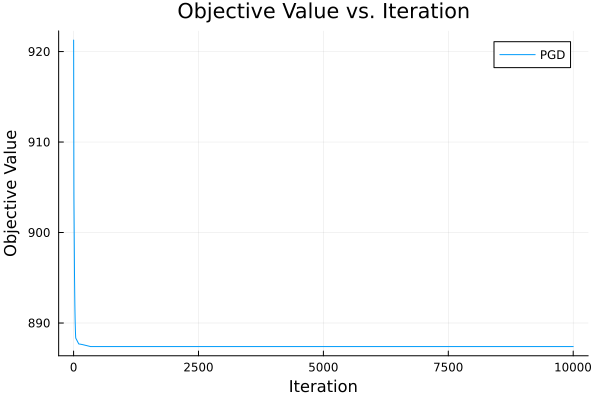

In [744]:
using Plots
plot(1:10000, obj_sto, xlabel="Iteration", ylabel="Objective Value", title="Objective Value vs. Iteration", label="PGD")

In [748]:
include("./reusablefunc.jl")
path_to_full_data = "C:/Users/Acer/Downloads/FTEC2101/Final Project/full_data_final/full_data_final/"
performance_testdata(path_to_full_data, x_gd)
performance_traindata(path_to_full_data, x_gd)

(Test) Sharpe Ratio = 0.07519127852597816, Return = 0.008714424805577244
 R-R ratio = 4.816281581593513 Variance = 0.013432056648452304, Selected stocks = 9
(Train) Sharpe Ratio = 0.10128842763660094, Return = 0.012759257688008894
 R-R ratio = -Inf Variance = 0.015868327622763027, Selected stocks = 9


0.10128842763660094

In [ ]:
path_to_extra_data = "C:/Users/Acer/Downloads/FTEC2101/Final Project/full_data_extra/full_data_extra/"
# Evaluate on extra data (2022)
performance_extradata(path_to_extra_data, x_gd)

In [ ]:
# limited exponential for numerical stability - Do not change this function -
function exp_limit( x )
    return exp( max( -1e2, min( x, 1e2 ) ) )
end

# define the objective functions & gradient
function obj_fct( x, beta, alp, gamma, upsilon, delta, T, bar_R, stocks_return )
    # Objective: CVaR + penalty terms + sparsity penalty
    # CVaR term: beta + (1/(1-alpha)) * (1/T) * sum(h_delta(-p^T R_t - beta))
    cvar_term = beta
    for t = 1:T
        loss = -dot(stocks_return[t,:], x) - beta
        h_delta = delta * log(1 + exp_limit(loss / delta))
        cvar_term += (1/(1-alp)) * (1/T) * h_delta
    end
    
    # Penalty terms
    # f1(p) = sum(p) - B <= 0, where B = 10
    B = 10
    f1 = sum(x) - B
    # f2(p) = Rd - sum(p * bar_R) <= 0, where Rd = 0.1
    Rd = 0.1
    f2 = Rd - dot(bar_R, x)
    
    # Sparsity penalty: gamma_s * sum(1 / (1 + exp(-lambda * p_i)))
    gamma_s = 0.1  # Tunable
    lambda = 10.0  # Tunable
    sparsity_term = 0.0
    for i = 1:length(x)
        sparsity_term += 1 / (1 + exp_limit(-lambda * x[i]))
    end
    sparsity_term *= gamma_s
    
    return cvar_term + gamma * f1 + upsilon * f2 + sparsity_term
end

function grd_fct_x( x, beta, alp, gamma, upsilon, delta, T, bar_R, stocks_return )
    # Gradient of objective w.r.t. x
    n = length(x)
    grad = zeros(n)
    
    # CVaR term gradient
    for t = 1:T
        loss = -dot(stocks_return[t,:], x) - beta
        sigmoid = exp_limit(loss / delta) / (1 + exp_limit(loss / delta))
        grad .+= (1/(1-alp)) * (1/T) * sigmoid * (-stocks_return[t,:])
    end
    
    # Penalty terms gradient
    # f1 = sum(x) - B, grad = ones(n)
    grad .+= gamma * ones(n)
    # f2 = Rd - sum(bar_R * x), grad = -bar_R
    grad .+= upsilon * (-bar_R)
    
    # Sparsity penalty gradient
    gamma_s = 0.1
    lambda = 10.0
    for i = 1:n
        exp_term = exp_limit(-lambda * x[i])
        grad[i] += gamma_s * lambda * exp_term / (1 + exp_term)^2
    end
    
    return grad
end

function grd_fct_beta( x, beta, alp, gamma, upsilon, delta, T, bar_R, stocks_return )
    # Gradient of objective w.r.t. beta
    grad_beta = 1.0  # From beta term
    
    # CVaR term gradient
    for t = 1:T
        loss = -dot(stocks_return[t,:], x) - beta
        sigmoid = exp_limit(loss / delta) / (1 + exp_limit(loss / delta))
        grad_beta += (1/(1-alp)) * (1/T) * sigmoid * (-1)
    end
    
    # No dependency on beta in penalty or sparsity terms
    return grad_beta
end

# projection
function projection_box( x, l )
    # Project onto [0,1]^n, l is lower bound (0), upper bound is 1
    return clamp.(x, 0, 1)
end

In [ ]:
x_gd_init = zeros(n); beta_init = 0;
# initialize GD
x_gd = copy(x_gd_init); beta_gd = copy(beta_init); stepsize = 0.01; alp = 0.95;
# set parameters
gamma = 10; # for budget constraint
upsilon = 1000; # for the expected return
delta = 0.01; # delta for log-function

# eval the objective value
obj_val = obj_fct( x_gd, beta_gd, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full )
print(obj_val, "\n")

obj_sto = []

for iteration_no = 1 : 1e4
    # calculate the gradient
    grad_x = grd_fct_x(x_gd, beta_gd, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full)
    grad_beta = grd_fct_beta(x_gd, beta_gd, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full)
    
    # gradient descent step
    x_gd = projection_box(x_gd - stepsize * grad_x, 0)
    beta_gd = beta_gd - stepsize * grad_beta  # beta is unconstrained
    
    # eval the objective value
    obj_val = obj_fct(x_gd, beta_gd, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full)
    push!(obj_sto, obj_val)

    if iteration_no % 50 == 0
        print("iter = ", iteration_no, " obj = ", obj_val, "\n")
    end
end

In [ ]:
using Plots
plot(1:10000, obj_sto, xlabel="Iteration", ylabel="Objective Value", title="Objective Value vs. Iteration", label="PGD")

In [ ]:
include("./reusablefunc.jl")
path_to_full_data = "C:/Users/Acer/Downloads/FTEC2101/Final Project/full_data_final/full_data_final/"
performance_testdata(path_to_full_data, x_gd)
performance_traindata(path_to_full_data, x_gd)

In [ ]:
path_to_extra_data = "C:/Users/Acer/Downloads/FTEC2101/Final Project/full_data_extra/full_data_extra/"
# Evaluate on extra data (2022)
performance_extradata(path_to_extra_data, x_gd)

#TESTING

Initial obj = 277.6080010441415
iter = 10 obj = 0.442260064158571 stepsize = 0.03125 gamma_s = 0.001 grad_norm = 1.1784244161698114 sum_x = 0.018030382329885287 non_zero = 1
iter = 20 obj = 0.441659432508834 stepsize = 0.015625 gamma_s = 0.001 grad_norm = 1.0871391179076275 sum_x = 0.01216924087445809 non_zero = 4
iter = 30 obj = 0.44165804551481413 stepsize = 0.0078125 gamma_s = 0.001 grad_norm = 1.0950402347738994 sum_x = 0.012121117497792815 non_zero = 4
iter = 40 obj = 0.4416577225862402 stepsize = 0.015625 gamma_s = 0.001 grad_norm = 1.1091412857515526 sum_x = 0.012177036722661105 non_zero = 4
iter = 50 obj = 0.4416577066068473 stepsize = 0.015625 gamma_s = 0.001 grad_norm = 1.1117072000602566 sum_x = 0.012158309934299418 non_zero = 4
iter = 60 obj = 0.4416577060017307 stepsize = 0.0078125 gamma_s = 0.001 grad_norm = 1.1120762181283672 sum_x = 0.012153850778744906 non_zero = 4
iter = 70 obj = 0.4416577059703011 stepsize = 0.015625 gamma_s = 0.001 grad_norm = 1.1122685371179812 sum

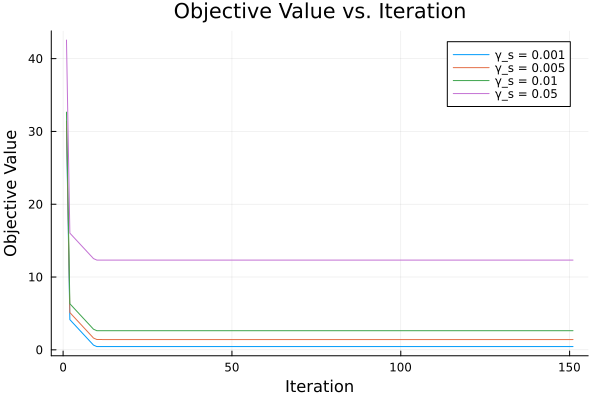

In [486]:
# Limited exponential for numerical stability
function exp_limit(x)
    return exp(max(-1e2, min(x, 1e2)))
end

# Define the objective functions & gradient
function obj_fct(x, beta, alp, gamma, upsilon, delta, T, bar_R, stocks_return; gamma_s=1.0)
    cvar_term = beta
    for t = 1:T
        loss = -dot(stocks_return[t,:], x) - beta
        h_delta = delta * log(1 + exp_limit(loss / delta))
        cvar_term += (1/(1-alp)) * (1/T) * h_delta
    end
    B = 10
    f1 = max(sum(x) - B, 0)^2
    Rd = 0.1
    f2 = max(Rd - dot(bar_R, x), 0)^2
    lambda = 5.0
    sparsity_term = 0.0
    for i = 1:length(x)
        sparsity_term += 1 / (1 + exp_limit(-lambda * x[i]))
    end
    sparsity_term *= gamma_s
    return cvar_term + gamma * f1 + upsilon * f2 + sparsity_term
end

function grd_fct_x(x, beta, alp, gamma, upsilon, delta, T, bar_R, stocks_return; gamma_s=1.0)
    n = length(x)
    grad = zeros(n)
    for t = 1:T
        loss = -dot(stocks_return[t,:], x) - beta
        sigmoid = exp_limit(loss / delta) / (1 + exp_limit(loss / delta))
        grad .+= (1/(1-alp)) * (1/T) * sigmoid * (-stocks_return[t,:])
    end
    grad .+= gamma * (sum(x) > B ? 2 * (sum(x) - B) * ones(n) : zeros(n))  # Corrected gradient
    grad .+= upsilon * (Rd > dot(bar_R, x) ? -2 * (Rd - dot(bar_R, x)) * bar_R : zeros(n))  # Corrected gradient
    lambda = 5.0
    for i = 1:n
        exp_term = exp_limit(-lambda * x[i])
        grad[i] += gamma_s * lambda * exp_term / (1 + exp_term)^2
    end
    return clamp.(grad, -10, 10)  # Gradient clipping
end

function grd_fct_beta(x, beta, alp, gamma, upsilon, delta, T, bar_R, stocks_return)
    grad_beta = 1.0
    for t = 1:T
        loss = -dot(stocks_return[t,:], x) - beta
        sigmoid = exp_limit(loss / delta) / (1 + exp_limit(loss / delta))
        grad_beta += (1/(1-alp)) * (1/T) * sigmoid * (-1)
    end
    return grad_beta
end

# Projection
function projection_box(x, l)
    return clamp.(x, 0, 1)
end

# Load and normalize data
files = glob("*_train.csv", "C:/Users/Acer/Downloads/FTEC2101/Final Project/full_data_final/full_data_final/")
dfs = DataFrame.(CSV.File.(files))
T = 1000; n = length(dfs)
stocks_return_full = zeros(T, n)
for i = 1:n
    if length(dfs[i].Close) < 1000
        println("Stock ", dfs[i].Ticker[1], " has less than 1000 data points")
    end
    stocks_return_full[:,i] = (dfs[i].Close .- dfs[i].Open) ./ dfs[i].Open
end
# Normalize returns
stocks_return_full = (stocks_return_full .- mean(stocks_return_full)) ./ std(stocks_return_full)
names_stocks_full = [dfs[i].Ticker[1] for i in 1:n]
bar_R_full = Float64[mean(stocks_return_full[:,i]) for i in 1:length(dfs)]
Sigma_full = [mean((stocks_return_full[:,i].-bar_R_full[i]).*(stocks_return_full[:,j].-bar_R_full[j])) for i=1:n, j=1:n]

# Initialize GD
top_indices = sortperm(bar_R_full, rev=true)[1:10]
x_gd_init = zeros(n)
x_gd_init[top_indices] .= 1.0
beta_init = 0
x_gd = copy(x_gd_init); beta_gd = copy(beta_init)
stepsize_init = 0.5
alp = 0.95; gamma = 0.1; upsilon = 0.1; delta = 0.05
backtracking_factor = 0.5
backtracking_max_iter = 10
tolerance = 1e-3
stagnation_count = 0
max_stagnation = 50
min_iterations = 100
max_iterations = 10000
path_to_full_data = "C:/Users/Acer/Downloads/FTEC2101/Final Project/full_data_final/full_data_final/"

# Evaluate initial objective
obj_sto = Float64[]
prev_obj = obj_fct(x_gd, beta_gd, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full)
push!(obj_sto, prev_obj)
println("Initial obj = ", prev_obj)

# Run PGD with multiple gamma_s
gamma_s_values = [0.001, 0.005, 0.01, 0.05]  # Adjusted to avoid zero portfolios
best_x_gd = nothing
best_beta_gd = nothing
best_sharpe = -Inf
results = []
obj_sto_dict = Dict()

for gamma_s_val in gamma_s_values
    x_gd = copy(x_gd_init)
    beta_gd = copy(beta_init)
    obj_sto = Float64[]
    prev_obj = obj_fct(x_gd, beta_gd, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full; gamma_s=gamma_s_val)
    push!(obj_sto, prev_obj)
    stagnation_count = 0
    
    for iteration_no = 1:max_iterations
        grad_x = grd_fct_x(x_gd, beta_gd, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full; gamma_s=gamma_s_val)
        grad_beta = grd_fct_beta(x_gd, beta_gd, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full)
        
        stepsize = stepsize_init
        current_obj = obj_fct(x_gd, beta_gd, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full; gamma_s=gamma_s_val)
        x_new = projection_box(x_gd - stepsize * grad_x, 0)
        beta_new = beta_gd - stepsize * grad_beta
        new_obj = obj_fct(x_new, beta_new, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full; gamma_s=gamma_s_val)
        
        for j = 1:backtracking_max_iter
            if new_obj <= current_obj
                break
            end
            stepsize *= backtracking_factor
            x_new = projection_box(x_gd - stepsize * grad_x, 0)
            beta_new = beta_gd - stepsize * grad_beta
            new_obj = obj_fct(x_new, beta_new, alp, gamma, upsilon, delta, T, bar_R_full, stocks_return_full; gamma_s=gamma_s_val)
        end
        
        x_gd = x_new
        beta_gd = beta_new
        obj_val = new_obj
        push!(obj_sto, obj_val)
        
        if iteration_no > min_iterations && abs(obj_val - prev_obj) < tolerance
            stagnation_count += 1
            if stagnation_count >= max_stagnation
                println("Stopping early at iteration ", iteration_no, " for gamma_s = ", gamma_s_val)
                break
            end
        else
            stagnation_count = 0
        end
        prev_obj = obj_val
        
        if iteration_no % 10 == 0
            println("iter = ", iteration_no, " obj = ", obj_val, " stepsize = ", stepsize, 
                    " gamma_s = ", gamma_s_val, " grad_norm = ", norm(grad_x), 
                    " sum_x = ", sum(x_gd), " non_zero = ", count(x_gd .> 1e-3))
        end
    end
    
    # Scale to budget
    if sum(x_gd) < 10 && sum(x_gd) > 0
        x_gd *= 10 / sum(x_gd)
        x_gd = projection_box(x_gd, 0)
    elseif sum(x_gd) == 0
        println("Warning: Zero portfolio for gamma_s = ", gamma_s_val)
    end
    
    # Evaluate portfolio
    sharpe_test = 0.0; ret_test = 0.0; rr_test = NaN; var_test = 0.0; num_stocks = 0
    sharpe_train = 0.0; ret_train = 0.0; rr_train = NaN; var_train = 0.0
    sharpe_extra = 0.0; ret_extra = 0.0; rr_extra = NaN; var_extra = 0.0
    if sum(x_gd) > 0
        try
            metrics_test = performance_testdata(path_to_full_data, x_gd)
            sharpe_test, ret_test, rr_test, var_test, num_stocks = metrics_test
            metrics_train = performance_traindata(path_to_full_data, x_gd)
            sharpe_train, ret_train, rr_train, var_train, _ = metrics_train
            path_to_extra_data = "C:/Users/Acer/Downloads/FTEC2101/Final Project/full_data_extra/full_data_extra/"
            metrics_extra = performance_extradata(path_to_extra_data, x_gd)
            sharpe_extra, ret_extra, rr_extra, var_extra, _ = metrics_extra
        catch e
            println("Error in performance evaluation for gamma_s = ", gamma_s_val, ": ", e)
        end
    else
        println("Skipping evaluation for zero portfolio, gamma_s = ", gamma_s_val)
    end
    
    push!(results, (gamma_s_val, copy(x_gd), beta_gd, sharpe_test, ret_test, rr_test, var_test, num_stocks, 
                    sharpe_train, ret_train, rr_train, var_train, sharpe_extra, ret_extra, rr_extra, var_extra))
    obj_sto_dict[gamma_s_val] = copy(obj_sto)
    
    if sharpe_test > best_sharpe
        best_sharpe = sharpe_test
        best_x_gd = copy(x_gd)
        best_beta_gd = beta_gd
    end
end

# Print results
for res in results
    println("gamma_s = ", res[1], 
            " Test: Sharpe = ", res[4], " Return = ", res[5], " R-R = ", res[6], " Variance = ", res[7], " Stocks = ", res[8],
            " Train: Sharpe = ", res[9], " Return = ", res[10], " R-R = ", res[11], " Variance = ", res[12],
            " Extra: Sharpe = ", res[13], " Return = ", res[14], " R-R = ", res[15], " Variance = ", res[16])
end

# Use best portfolio
x_gd = best_x_gd
beta_gd = best_beta_gd

# Plot objective values
using Plots
plt = plot(xlabel="Iteration", ylabel="Objective Value", title="Objective Value vs. Iteration")
for gamma_s_val in gamma_s_values
    obj_sto = obj_sto_dict[gamma_s_val]
    plot!(1:length(obj_sto), obj_sto, label="γ_s = $gamma_s_val")
end
display(plt)

In [488]:
include("./reusablefunc.jl")
path_to_full_data = "C:/Users/Acer/Downloads/FTEC2101/Final Project/full_data_final/full_data_final/"
performance_testdata(path_to_full_data, x_gd)
performance_traindata(path_to_full_data, x_gd)

(Test) Sharpe Ratio = 0.07730673986245679, Return = 0.005482226964487451
 R-R ratio = 5.0755451366532185 Variance = 0.005028973013636047, Selected stocks = 18
(Train) Sharpe Ratio = 0.12575753085455052, Return = 0.010665783344566027
 R-R ratio = -Inf Variance = 0.007193123412885836, Selected stocks = 18


0.12575753085455052

In [489]:
path_to_extra_data = "C:/Users/Acer/Downloads/FTEC2101/Final Project/full_data_extra/full_data_extra/"
# Evaluate on extra data (2022)
performance_extradata(path_to_extra_data, x_gd)

(Extra) Sharpe Ratio = 0.029253424586702853, Return = 0.0033065889670213086
 R-R ratio = 8.996881485926078 Variance = 0.012776355734756849, Selected stocks = 18


0.029253424586702853